In [1]:
import numpy as np
import matplotlib.pyplot as plt
from Base_Files.ClassLevyJumpProcesses import TemperedStableSubordinator
import GPy
from Base_Files.Creating_the_NGP import GaussianProcess


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


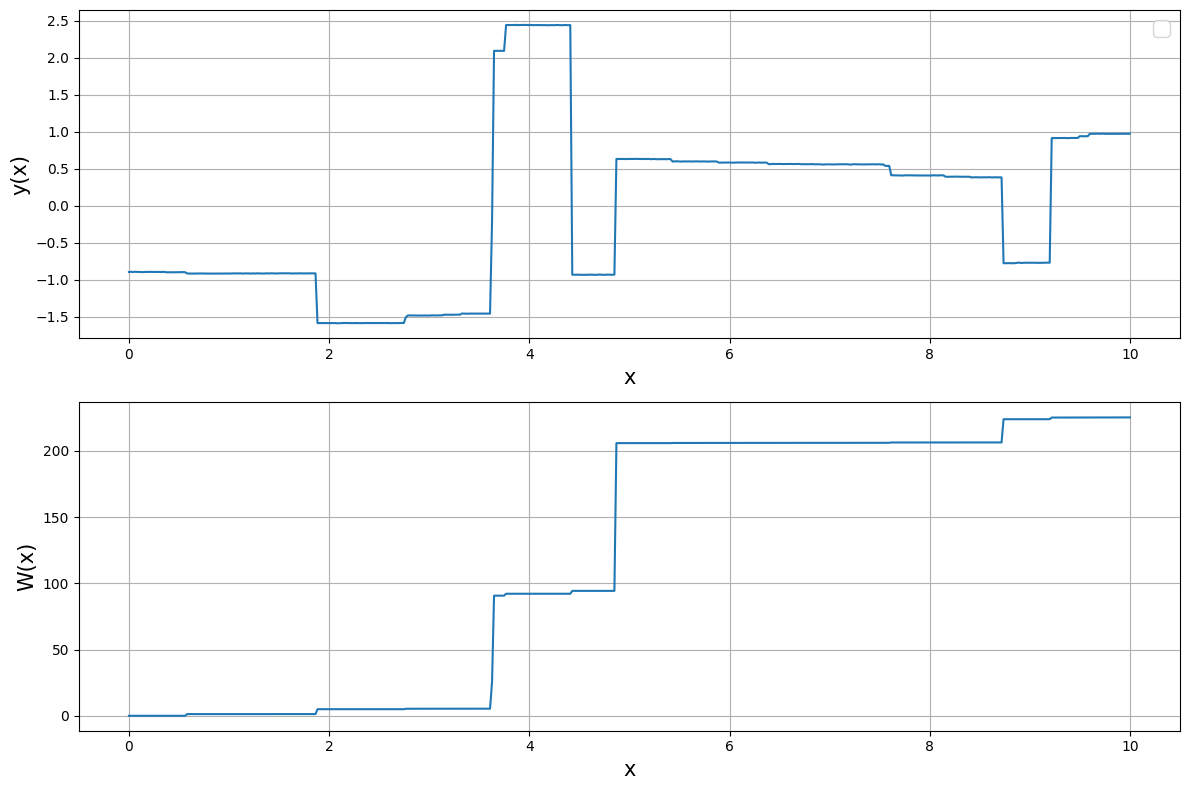

In [9]:
# Set Parameters
t1 = 0.0
t2 = 10.0

num_obs = 500 # (N) number of points e.g. size of data set
num_epochs = 2000
subordinator_truncation = 0.0
kappa = 0.2
delta = 1.2
gamma = 0.3
nProcesses = 1
l = 1

initial_sub = TemperedStableSubordinator(t1, t2, num_obs, num_epochs, subordinator_truncation, kappa=kappa, delta=delta, gamma=gamma).generate_path().reshape(-1,1)
X = initial_sub
Y = GaussianProcess(initial_sub, 1, num_obs).reshape(-1,1)

Xs = np.linspace(0.0, 10.0, num_obs).reshape(-1, 1)

fig, ax = plt.subplots(nrows=2, figsize=(12,8))

ax[0].plot(Xs, Y)
ax[0].set_xlabel('x', fontsize=15)
ax[0].set_ylabel('y(x)', fontsize=15)
ax[0].grid(True)
ax[0].legend(fontsize=15)

ax[1].plot(Xs, initial_sub)
ax[1].set_xlabel('x', fontsize=15)
ax[1].set_ylabel('W(x)', fontsize=15)
ax[1].grid(True)

plt.tight_layout()
plt.show()

In [10]:
# Log--likelihood function

def log_likelihood(X, Y):
    kernel = GPy.kern.RBF(input_dim=1)
    sub_kernel = GPy.kern.Brownian(input_dim=1)
    model = GPy.models.GPRegression(X, Y, kernel*sub_kernel)
    log_likelihood = model.log_likelihood()
    return log_likelihood

num_iter = 5000
burn_in = 0

Number of accepted likelihood samples: 16
Accepted Likelihood samples: [-593.4461914460858, -579.9565439312595, -576.6506744139986, -564.621973176654, -555.916517249585, -555.4194575677253, -552.1825227184817, -549.735115435119, -544.9952017364209, -545.1452827338085, -545.5985675608865, -544.8500946068004, -538.4412141177296, -533.0902686646696, -533.1434355153676, -524.6311564592661]
Accepted Alphas: [71.08648363607185, 721904.0503749965, 27.27224496980377, 167493.7368058941, 6035.7531759928515, 1.643880625645287, 25.455576864929895, 11.55834033571865, 114.42432628571451, 0.8606382641507834, 0.635537089672284, 2.113769727415221, 607.2135182376527, 210.8075122854627, 0.9482217878155024, 4975.489596470826]
-512.2499430678029


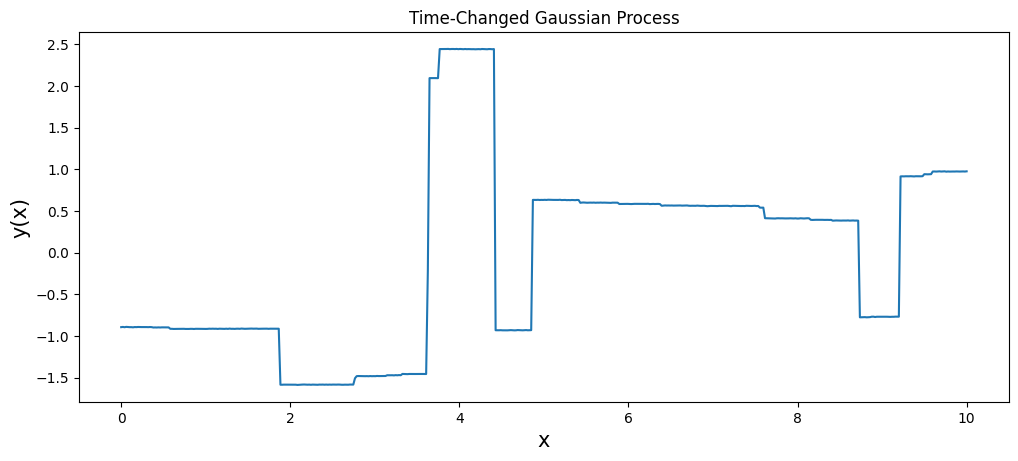

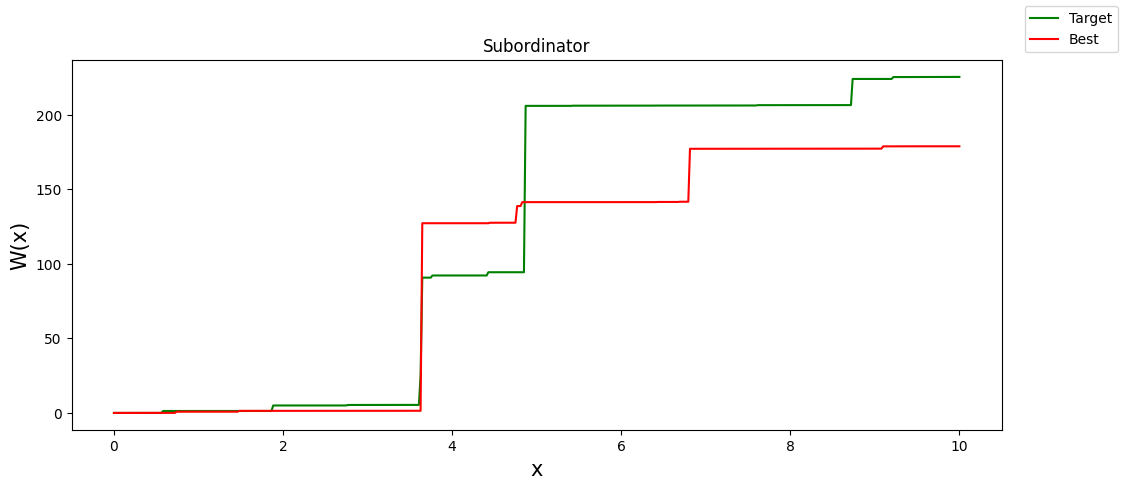

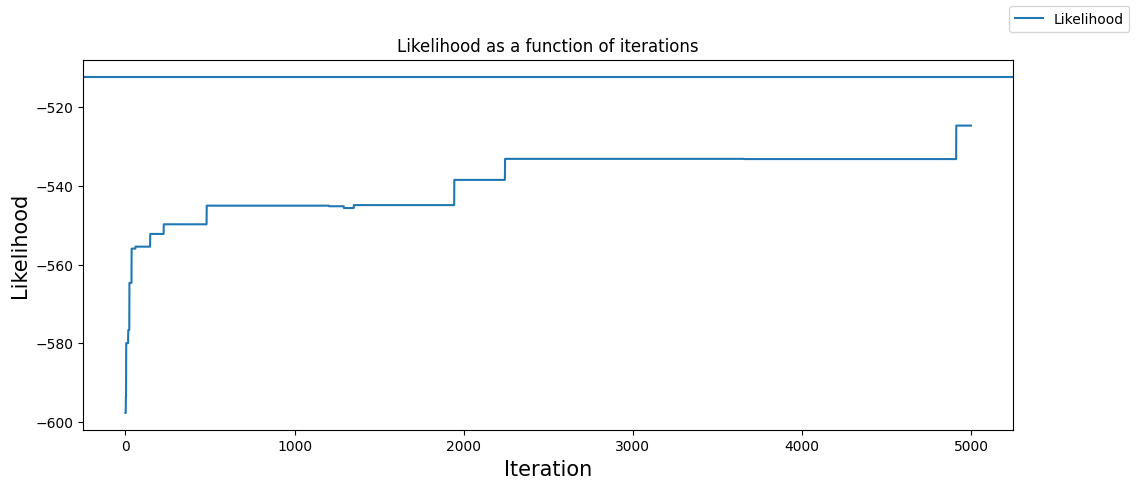

In [11]:
# Overall RUN

# Run the Metropolis-Hastings algorithm



t1 = 0.0
t2 = 10.0

N = 1

current_sub = TemperedStableSubordinator(t1, t2, int(num_obs/N), num_epochs, subordinator_truncation, kappa=kappa, delta=delta, gamma=gamma).generate_path().reshape(-1,1)
acceptances = 0

accept_sub_samples = []

likelihood_samples = []
accept_likelihood_samples = []

alphas = []
accept_alphas = []


for i in range(num_iter):
    # Draw a new proposal from the proposal distribution
#     print('Iteration:', i+1)

    new_sub = TemperedStableSubordinator(t1, t2, int(num_obs/N), num_epochs, subordinator_truncation, kappa=kappa, delta=delta, gamma=gamma).generate_path().reshape(-1,1)
    log_alpha = log_likelihood(new_sub, Y) - log_likelihood(current_sub, Y)
    alpha = np.exp(log_alpha)

    accept = np.random.uniform() < alpha
    alphas.append(alpha)

    if accept:
        current_sub = new_sub

        acceptances += 1

        accept_likelihood_samples.append(log_likelihood(current_sub, Y))

        accept_alphas.append(alpha)

        accept_sub_samples.append(current_sub)

    likelihood_samples.append(log_likelihood(current_sub, Y))


# Print the acceptance rate
#print('Acceptance rate:', acceptances*100 / num_iter, '%')
print('Number of accepted likelihood samples:', acceptances)
print('Accepted Likelihood samples:', accept_likelihood_samples)
print('Accepted Alphas:', accept_alphas)
print(log_likelihood(X, Y))

Xs = np.linspace(0, 10, int(num_obs/N))

plt.figure(1).set_figwidth(12)
plt.xlabel('x', fontsize=15)
plt.ylabel('y(x)', fontsize=15)
plt.title('Time-Changed Gaussian Process')
plt.plot(Xs, Y)

plt.figure(2).set_figwidth(12)
plt.plot(Xs, initial_sub, label='Target', color='green')
plt.plot(Xs, accept_sub_samples[-1], label='Best', color='red')
plt.title('Subordinator')
plt.xlabel('x', fontsize=15)
plt.ylabel('W(x)', fontsize=15)
plt.figure(2).legend()

plt.figure(3).set_figwidth(12)
plt.plot(np.linspace(1, len(likelihood_samples), len(likelihood_samples)), likelihood_samples, label='Likelihood')
plt.axhline(log_likelihood(X, Y))
plt.title('Likelihood as a function of iterations')
plt.xlabel('Iteration', fontsize=15)
plt.ylabel('Likelihood', fontsize=15)
plt.figure(3).legend()


plt.show()



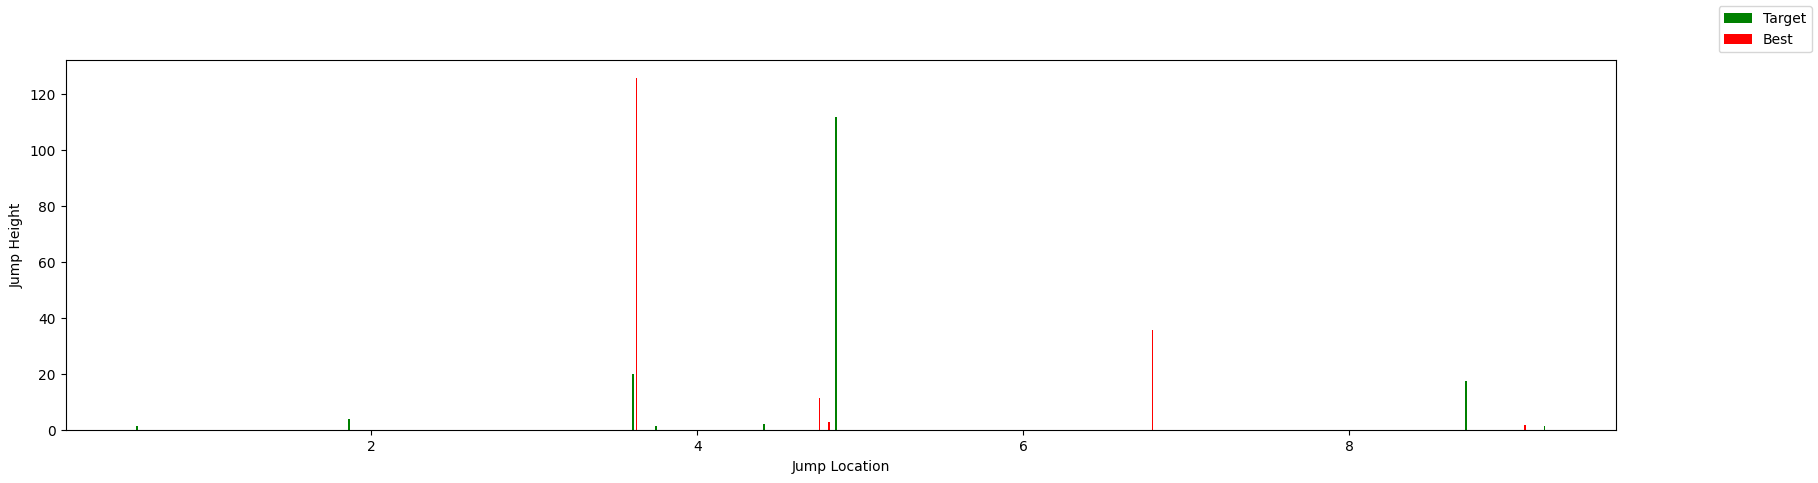

In [53]:
# Displaying only jumps and their location of the subordinators
# Green is the inital or target
# Red is the subordinator proposed by the algorithm

X_jump = []
Y_jump = []
X1_jump= []
Y1_jump= []

length = len(initial_sub)

for i in range(length-1):
    difference = 1
    if initial_sub[i+1] - initial_sub[i] > difference:
        X_jump.append(Xs[i])
        Y_jump.append((initial_sub[i+1] - initial_sub[i])[0])

    if accept_sub_samples[-1][i+1] - accept_sub_samples[-1][i] > difference:
        X1_jump.append(Xs[i])
        Y1_jump.append((accept_sub_samples[-1][i+1] - accept_sub_samples[-1][i])[0])

plt.figure(3).set_figwidth(20)
plt.bar(X_jump,Y_jump, width = 0.01, color='green', label='Target')
plt.bar(X1_jump,Y1_jump, width = 0.01, color='red', label='Best')
plt.xlabel('Jump Location')
plt.ylabel('Jump Height')
plt.figure(3).legend()

t1 = 0.0
t2 = 5.0

current_sub = TemperedStableSubordinator(t1, t2, int(num_obs/2), num_epochs, subordinator_truncation, kappa=kappa, delta=delta, gamma=gamma).generate_path().reshape(-1,1)
print(len(current_sub))
print(current_sub[-1])
print(accept_sub_samples[-1][-1])
print(abs(accept_sub_samples[-1][250]-current_sub[-1]))

diff = current_sub[-1] - accept_sub_samples[-1][250]
addon = accept_sub_samples[-1][250:] + diff

total = np.concatenate((current_sub, addon))

plt.plot(np.linspace(0, 5, int(num_obs/2)), current_sub)
plt.plot(np.linspace(5, 10, int(num_obs/2)), accept_sub_samples[-1][250:])
plt.plot(np.linspace(5, 10, int(num_obs/2)), addon)
plt.plot(np.linspace(0, 10, int(num_obs)), total)
plt.show()

Number of accepted likelihood samples: 2
Accepted Likelihood samples: [-523.1934741853433, -513.7019047186279]
Accepted Alphas: [4.210924727965342, 13247.57064047511]


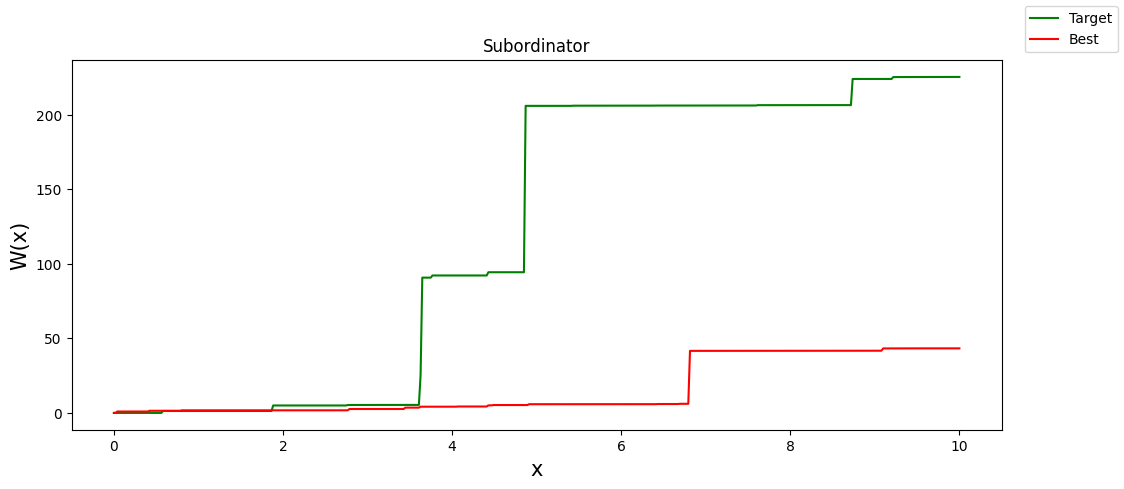

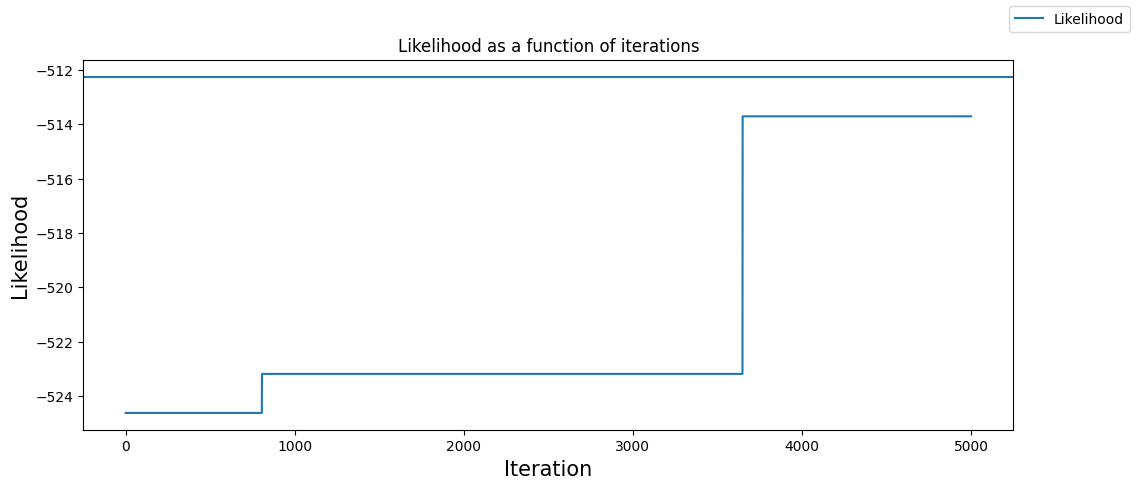

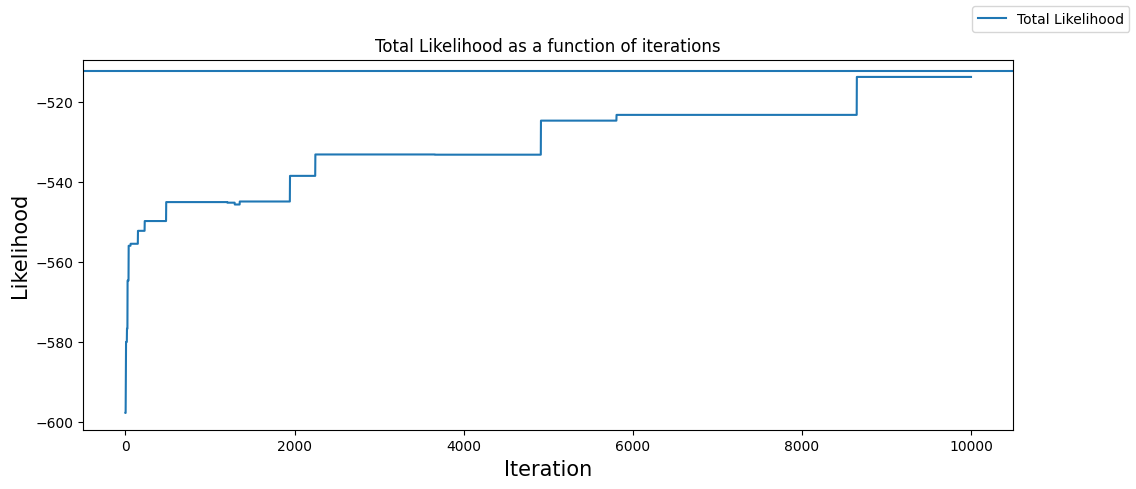

In [13]:
# Running on first half to optimise result

# Run the Metropolis-Hastings algorithm
t1 = 0.0
t2 = 5.0

N = 2

#current_sub = TemperedStableSubordinator(t1, t2, int(num_obs/N), num_epochs, subordinator_truncation, kappa=kappa, delta=delta, gamma=gamma).generate_path().reshape(-1,1)
#diff1 = current_sub[-1] - accept_sub_samples[-1][250]
#addon1 = accept_sub_samples[-1][250:] + diff1
#total1 = np.concatenate((current_sub, addon1))
total1 = accept_sub_samples[-1]

acceptances1 = 0

accept_sub_samples_1 = []

likelihood_samples1 = []
accept_likelihood_samples1 = []

alphas1 = []
accept_alphas1 = []


for i in range(num_iter):
    # Draw a new proposal from the proposal distribution
#     print('Iteration:', i+1)


    new_sub = TemperedStableSubordinator(t1, t2, int(num_obs/N), num_epochs, subordinator_truncation, kappa=kappa, delta=delta, gamma=gamma).generate_path().reshape(-1,1)
    diff2 = new_sub[-1] - accept_sub_samples[-1][250]
    addon2 = accept_sub_samples[-1][250:] + diff2
    total2 = np.concatenate((new_sub, addon2))


    log_alpha = log_likelihood(total2, Y) - log_likelihood(total1, Y)
    alpha = np.exp(log_alpha)

    accept = np.random.uniform() < alpha
    alphas1.append(alpha)

    if accept:
        total1 = total2

        acceptances1 += 1

        accept_likelihood_samples1.append(log_likelihood(total1, Y))

        accept_alphas1.append(alpha)

        accept_sub_samples_1.append(total1)

    likelihood_samples1.append(log_likelihood(total1, Y))

    
# Print the acceptance rate
#print('Acceptance rate:', acceptances*100 / num_iter, '%')
print('Number of accepted likelihood samples:', acceptances1)
print('Accepted Likelihood samples:', accept_likelihood_samples1)
print('Accepted Alphas:', accept_alphas1)
#print(log_likelihood(X[:250], Y1))

Xs = np.linspace(0, 10, int(num_obs))

#plt.figure(1).set_figwidth(12)
#plt.xlabel('x', fontsize=15)
#plt.ylabel('y(x)', fontsize=15)
#plt.title('Time-Changed Gaussian Process')
#plt.plot(Xs, Y1)


plt.figure(2).set_figwidth(12)
plt.plot(Xs, initial_sub, label='Target', color='green')
plt.plot(Xs, accept_sub_samples_1[-1], label='Best', color='red')
plt.title('Subordinator')
plt.xlabel('x', fontsize=15)
plt.ylabel('W(x)', fontsize=15)
plt.figure(2).legend()

plt.figure(3).set_figwidth(12)
plt.plot(np.linspace(1, len(likelihood_samples1), len(likelihood_samples1)), likelihood_samples1, label='Likelihood')
plt.axhline(log_likelihood(X, Y))
plt.title('Likelihood as a function of iterations')
plt.xlabel('Iteration', fontsize=15)
plt.ylabel('Likelihood', fontsize=15)
plt.figure(3).legend()

total_likelihood = likelihood_samples + likelihood_samples1

plt.figure(4).set_figwidth(12)
plt.plot(np.linspace(1, len(total_likelihood), len(total_likelihood)), total_likelihood, label='Total Likelihood')
plt.axhline(log_likelihood(X, Y))
plt.title('Total Likelihood as a function of iterations')
plt.xlabel('Iteration', fontsize=15)
plt.ylabel('Likelihood', fontsize=15)
plt.figure(4).legend()


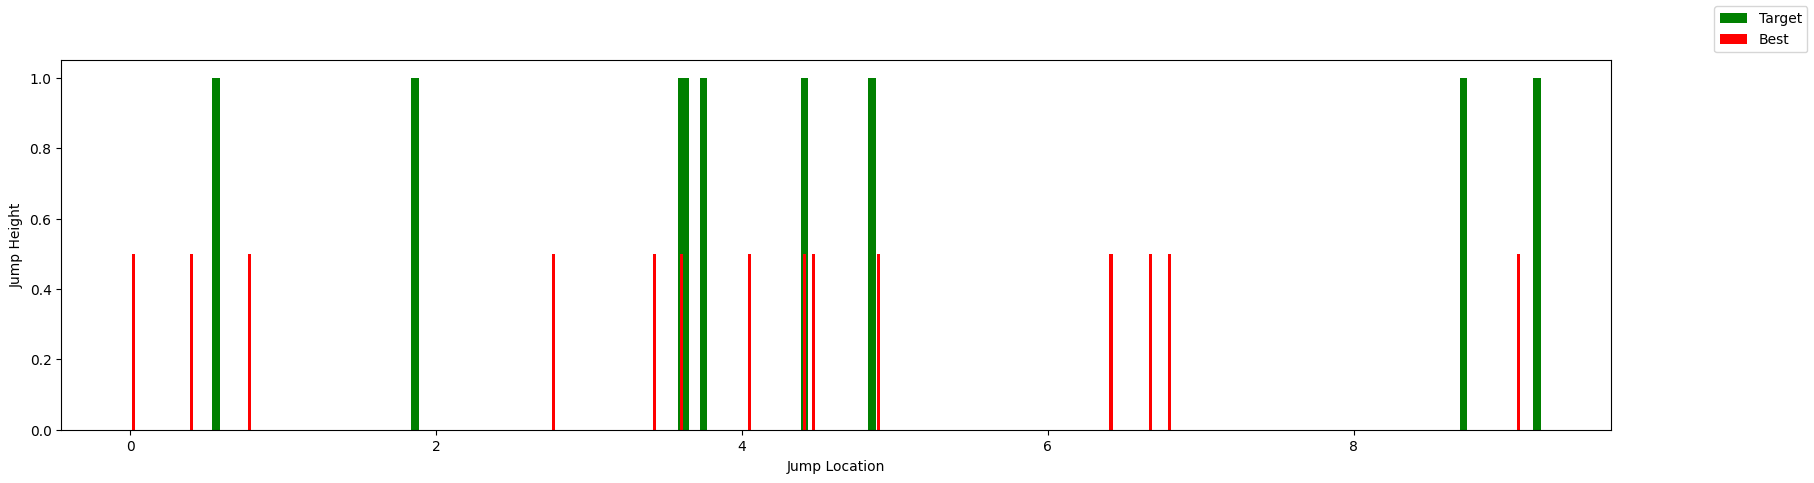

In [21]:
X2_jump= []
#Y2_jump= []

length = len(initial_sub)

for i in range(length-1):
    difference = 0.1
    if accept_sub_samples_1[-1][i+1] - accept_sub_samples_1[-1][i] > difference:
        X2_jump.append(Xs[i])
        #Y2_jump.append((accept_sub_samples_1[-1][i+1] - accept_sub_samples_1[-1][i])[0])

Y_jump = [1]*len(X_jump)
Y2_jump= [0.5]*len(X2_jump)

plt.figure(3).set_figwidth(20)
plt.bar(X_jump,Y_jump, width = 0.05, color='green', label='Target')
plt.bar(X2_jump,Y2_jump, width = 0.02, color='red', label='Best')
plt.xlabel('Jump Location')
plt.ylabel('Jump Height')
plt.figure(3).legend()

t1 = 5.0
t2 = 10.0

current_sub = TemperedStableSubordinator(t1, t2, int(num_obs/2), num_epochs, subordinator_truncation, kappa=kappa, delta=delta, gamma=gamma).generate_path().reshape(-1,1)
print(len(current_sub))
print(accept_sub_samples_1[-1][250])
#print(accept_sub_samples[-1][-1])
#print(abs(accept_sub_samples[-1][250]-current_sub[-1]))

diff = accept_sub_samples_1[-1][250]
addon = current_sub + diff
total = np.concatenate((accept_sub_samples_1[-1][:250], addon))

plt.plot(np.linspace(5, 10, int(num_obs/2)), current_sub)
plt.plot(np.linspace(0, 10, int(num_obs)), accept_sub_samples_1[-1])
#plt.plot(np.linspace(5, 10, int(num_obs/2)), accept_sub_samples[-1][250:])
plt.plot(np.linspace(5, 10, int(num_obs/2)), addon)
plt.plot(np.linspace(0, 10, int(num_obs)), total)
plt.show()

Number of accepted likelihood samples: 45
Accepted Likelihood samples: [-513.76711563556, -511.46061163280945, -511.183209280852, -513.1727884812008, -513.0313581172819, -513.7249138815425, -513.6793665903134, -514.2599497794135, -515.5121143062142, -515.7662055005874, -510.2002888668198, -512.8992768030397, -512.8638532207822, -512.3014852696191, -510.6706946705479, -509.6517375616082, -509.7284900661968, -510.6920577680787, -515.4671559079987, -514.6875690197387, -516.2271035235183, -516.4522134655762, -517.6382349392119, -518.9252310519604, -518.9690302778456, -518.1221047066675, -516.3149159569567, -516.5727803549063, -513.8104478161466, -511.32636377004013, -511.70101189142605, -510.31481668976693, -511.76641071010374, -511.3894175140453, -513.1972910007078, -513.5306748746445, -512.889854288511, -517.7608523200909, -517.0350286347033, -516.416910560236, -518.5988119139994, -518.2555448519691, -512.9763596791369, -511.02763036145683, -510.7494959278713]
Accepted Alphas: [0.9368698

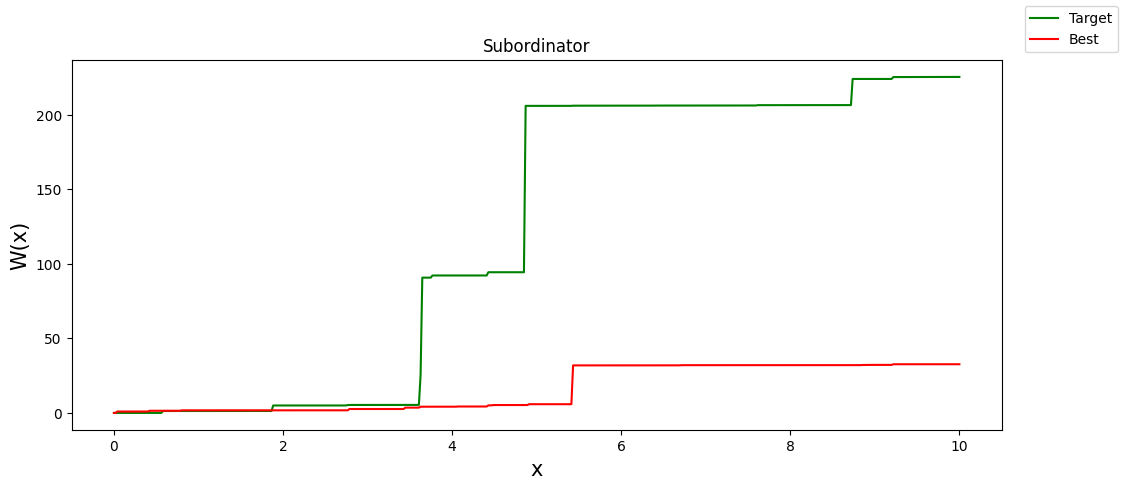

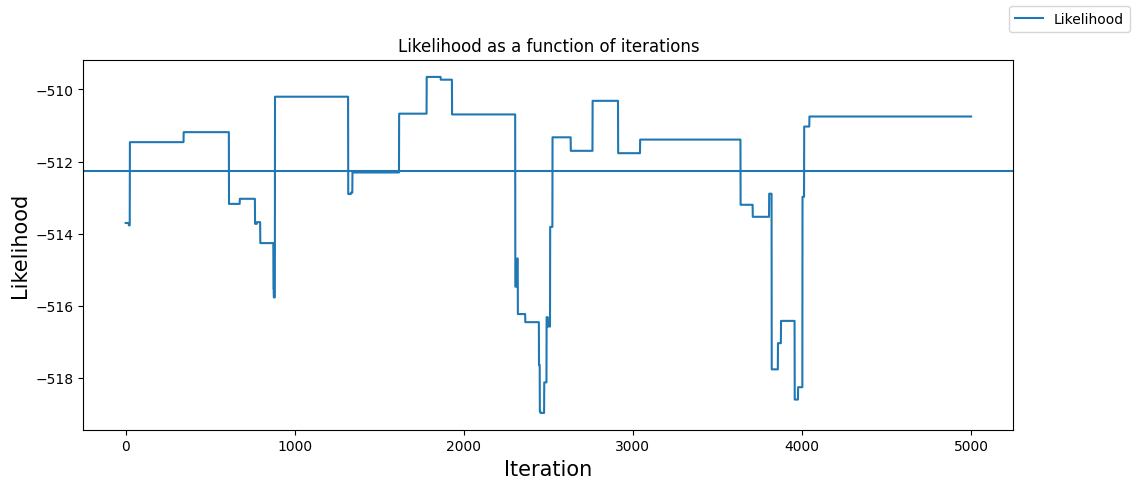

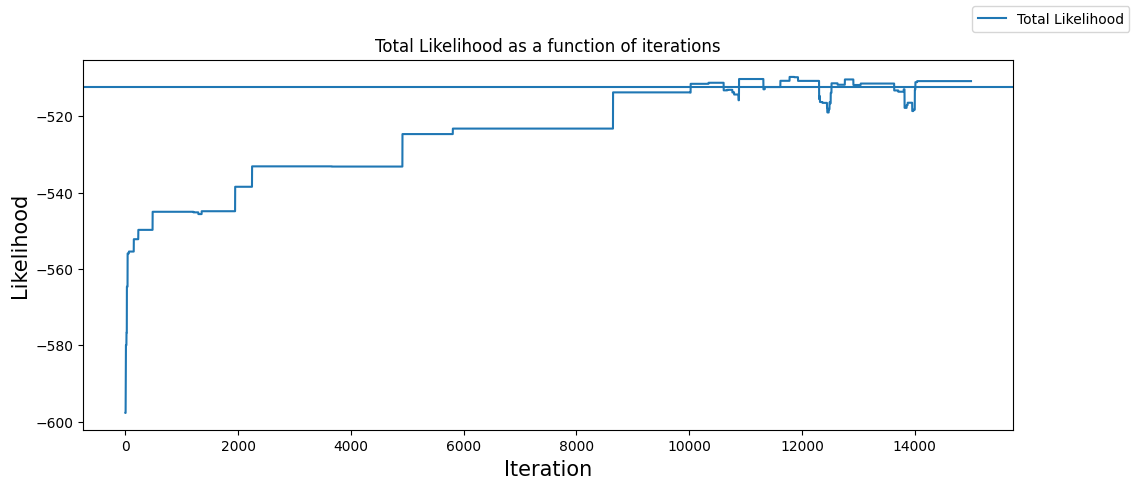

In [17]:
# Running on second half to optimise result

# Run the Metropolis-Hastings algorithm
t1 = 5.0
t2 = 10.0

N = 2

#current_sub = TemperedStableSubordinator(t1, t2, int(num_obs/N), num_epochs, subordinator_truncation, kappa=kappa, delta=delta, gamma=gamma).generate_path().reshape(-1,1)
#diff3 = accept_sub_samples_1[-1][250]
#addon3 = current_sub + diff3
#total3 = np.concatenate((accept_sub_samples_1[-1][:250], addon3))
total3 = accept_sub_samples_1[-1]

acceptances2 = 0

accept_sub_samples_2 = []

likelihood_samples2 = []
accept_likelihood_samples2 = []

alphas2 = []
accept_alphas2 = []


for i in range(num_iter):
    # Draw a new proposal from the proposal distribution
#     print('Iteration:', i+1)

    new_sub = TemperedStableSubordinator(t1, t2, int(num_obs/N), num_epochs, subordinator_truncation, kappa=kappa, delta=delta, gamma=gamma).generate_path().reshape(-1,1)
    diff4 = accept_sub_samples_1[-1][250]
    addon4 = new_sub + diff4
    total4 = np.concatenate((accept_sub_samples_1[-1][:250], addon4))

    log_alpha = log_likelihood(total4, Y) - log_likelihood(total3, Y)
    alpha = np.exp(log_alpha)

    accept = np.random.uniform() < alpha
    alphas2.append(alpha)

    if accept:
        total3 = total4

        acceptances2 += 1

        accept_likelihood_samples2.append(log_likelihood(total3, Y))

        accept_alphas2.append(alpha)

        accept_sub_samples_2.append(total3)

    likelihood_samples2.append(log_likelihood(total3, Y))

    
# Print the acceptance rate
#print('Acceptance rate:', acceptances*100 / num_iter, '%')
print('Number of accepted likelihood samples:', acceptances2)
print('Accepted Likelihood samples:', accept_likelihood_samples2)
print('Accepted Alphas:', accept_alphas2)
print(log_likelihood(X, Y))

Xs = np.linspace(0, 10, int(num_obs))

#plt.figure(1).set_figwidth(12)
#plt.xlabel('x', fontsize=15)
#plt.ylabel('y(x)', fontsize=15)
#plt.title('Time-Changed Gaussian Process')
#plt.plot(Xs, Y1)


plt.figure(2).set_figwidth(12)
plt.plot(Xs, initial_sub, label='Target', color='green')
plt.plot(Xs, accept_sub_samples_2[-1], label='Best', color='red')
plt.title('Subordinator')
plt.xlabel('x', fontsize=15)
plt.ylabel('W(x)', fontsize=15)
plt.figure(2).legend()

plt.figure(3).set_figwidth(12)
plt.plot(np.linspace(1, len(likelihood_samples2), len(likelihood_samples2)), likelihood_samples2, label='Likelihood')
plt.axhline(log_likelihood(X, Y))
plt.title('Likelihood as a function of iterations')
plt.xlabel('Iteration', fontsize=15)
plt.ylabel('Likelihood', fontsize=15)
plt.figure(3).legend()

total_likelihood = likelihood_samples + likelihood_samples1 + likelihood_samples2

plt.figure(4).set_figwidth(12)
plt.plot(np.linspace(1, len(total_likelihood), len(total_likelihood)), total_likelihood, label='Total Likelihood')
plt.axhline(log_likelihood(X, Y))
plt.title('Total Likelihood as a function of iterations')
plt.xlabel('Iteration', fontsize=15)
plt.ylabel('Likelihood', fontsize=15)
plt.figure(4).legend()

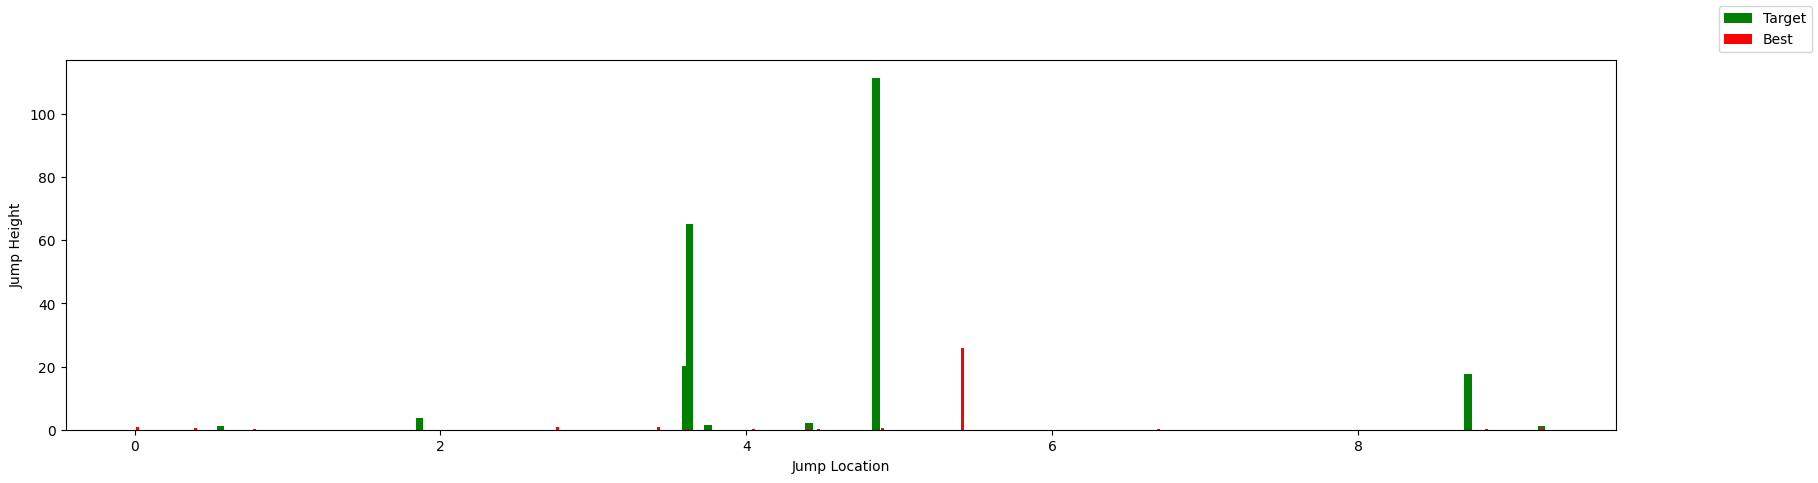

In [58]:
X3_jump= []
Y3_jump= []

length = len(initial_sub)

for i in range(length-1):
    difference = 0.01
    if accept_sub_samples_2[-1][i+1] - accept_sub_samples_2[-1][i] > difference:
        X3_jump.append(Xs[i])
        Y3_jump.append((accept_sub_samples_2[-1][i+1] - accept_sub_samples_2[-1][i])[0])

#Y_jump = [1]*len(X_jump)
#Y3_jump= [0.5]*len(X3_jump)

plt.figure(3).set_figwidth(20)
plt.bar(X_jump,Y_jump, width = 0.05, color='green', label= 'Target')
plt.bar(X3_jump,Y3_jump, width = 0.02, color='red', label='Best')
plt.xlabel('Jump Location')
plt.ylabel('Jump Height')
plt.figure(3).legend()

In [47]:
def jump_density_estimate(x_grid, locations, magnitudes):
    def weighted_Gaussian_kernel(x, mu, sigma, weight):
        u = (x - mu) / abs(sigma)
        y = (1 / (np.sqrt(2 * np.pi) * abs(sigma))) * np.exp(-u * u / 2) * weight
        return y
    prob = [weighted_Gaussian_kernel(x_i, locations, 0.001, magnitudes) for x_i in x_grid]
    density = [np.average(pr) for pr in prob]
    return np.array(density)

In [48]:
x_grid=np.linspace(0, 10, 500)
locations = X_jump
magnitudes= Y_jump

In [49]:
def jump_density_estimate(x_grid, locations, magnitudes):
    def weighted_Gaussian_kernel(x, mu, sigma, weight):
        u = (x - mu) / abs(sigma)
        y = (1 / (np.sqrt(2 * np.pi) * abs(sigma))) * np.exp(-u * u / 2) * weight
        return y
    prob = [weighted_Gaussian_kernel(x_i, locations, 0.001, magnitudes) for x_i in x_grid]
    density = [np.average(pr) for pr in prob]
    return np.array(density)

In [43]:
jump_density_estimate(x_grid, locations, magnitudes)

array([0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 2.74973282e-86,
       4.43269200e+01, 2.74973282e-86, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
      

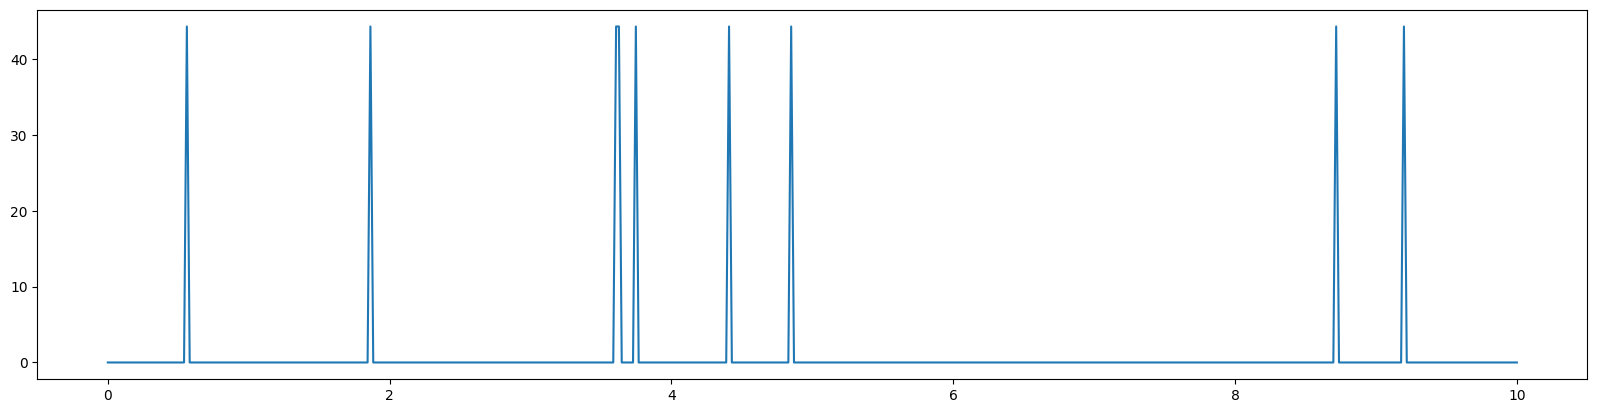

In [54]:
plt.figure().set_figwidth(20)
plt.plot(x_grid, jump_density_estimate(x_grid, locations, magnitudes))

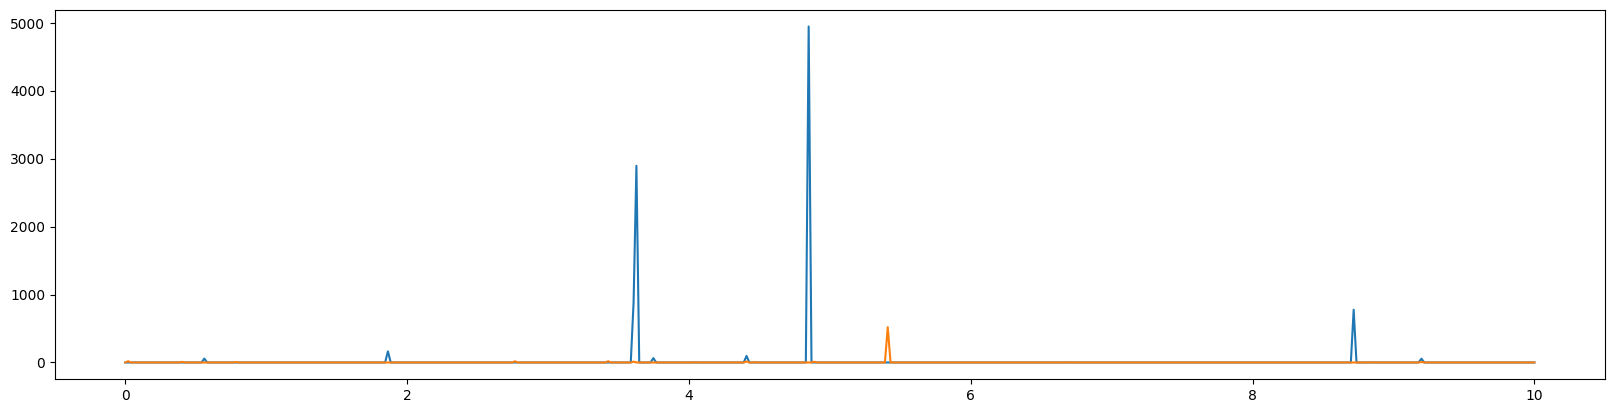

In [59]:
plt.figure().set_figwidth(20)
plt.plot(np.linspace(0, 10, 500), jump_density_estimate(np.linspace(0, 10, 500), X_jump, Y_jump))
plt.plot(np.linspace(0, 10, 500), jump_density_estimate(np.linspace(0, 10, 500), X3_jump, Y3_jump))